<a href="https://colab.research.google.com/github/EmmaMuhleman1/Adv_Fin_ML_Exercises/blob/master/NDX_GradientBoosting_ChatGPT_UNORDEREDMESS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NDX Gradient Boosting Final Report

This notebook executes the complete predictive modeling pipeline on the Nasdaq-100 index, using XGBoost and confidence-weighted strategy backtesting.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import (roc_auc_score, roc_curve, accuracy_score,
                             confusion_matrix, classification_report, auc)
from xgboost import XGBClassifier
import shap
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid', context='notebook')

In [24]:
df = yf.download('^NDX', start='2008-01-01', progress=False).reset_index()
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
df['Return'] = df['Close'].pct_change()
df['Target'] = (df['Return'].shift(-1) > 0).astype(int)

In [25]:
df.head()

,Date,Open,High,Low,Close,Volume,Return,Target
0,2008-01-02,2049.709961,2094.219971,2040.430054,2085.530029,2076690000,NaN,0
1,2008-01-03,2051.760010,2064.729980,2040.010010,2050.639893,1970200000,-0.016730,0
2,2008-01-04,1963.520020,2025.359985,1963.020020,2025.359985,2516310000,-0.012328,0
3,2008-01-07,1957.439941,1975.869995,1929.270020,1971.280029,2600100000,-0.026701,0
4,2008-01-08,1910.329956,1983.140015,1910.329956,1965.420044,2566480000,-0.002973,0


In [26]:
df.reset_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4408 entries, 0 to 4407
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4408 non-null   datetime64[ns]
 1   Open    4408 non-null   float64       
 2   High    4408 non-null   float64       
 3   Low     4408 non-null   float64       
 4   Close   4408 non-null   float64       
 5   Volume  4408 non-null   int64         
 6   Return  4407 non-null   float64       
 7   Target  4408 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 275.6 KB


In [27]:
df.describe()

,Date,Open,High,Low,Close,Volume,Return,Target
count,4408,4408.000000,4408.000000,4408.000000,4408.000000,4.408000e+03,4407.000000,4408.000000
mean,2016-10-02 06:51:17.313974528,7295.954272,7346.234143,7238.181251,7293.819650,3.047115e+09,0.000645,0.560799
min,2008-01-02 00:00:00,1036.510010,1085.569946,1018.859985,1058.849976,2.214300e+08,-0.108057,0.000000
25%,2012-05-15 18:00:00,2611.795044,2629.127502,2593.372559,2605.172485,1.852662e+09,-0.005672,0.000000
50%,2016-10-01 12:00:00,4805.520020,4822.885010,4790.470215,4807.620117,2.171205e+09,0.001431,1.000000
75%,2021-02-18 06:00:00,11710.282715,11802.027832,11565.955078,11686.202881,4.262782e+09,0.007818,1.000000
max,2025-07-10 00:00:00,22866.970703,22915.330078,22736.080078,22890.400391,1.630873e+10,0.098797,1.000000
std,NaN,5705.373182,5745.300460,5659.295708,5703.786457,1.819522e+09,0.014186,0.496346


In [28]:
from google.colab import data_table
data_table.enable_dataframe_formatter()
df

,Date,Open,High,Low,Close,Volume,Return,Target
0,2008-01-02,2049.709961,2094.219971,2040.430054,2085.530029,2076690000,NaN,0
1,2008-01-03,2051.760010,2064.729980,2040.010010,2050.639893,1970200000,-0.016730,0
2,2008-01-04,1963.520020,2025.359985,1963.020020,2025.359985,2516310000,-0.012328,0
3,2008-01-07,1957.439941,1975.869995,1929.270020,1971.280029,2600100000,-0.026701,0
4,2008-01-08,1910.329956,1983.140015,1910.329956,1965.420044,2566480000,-0.002973,0
...,...,...,...,...,...,...,...,...
4403,2025-07-03,22866.970703,22896.009766,22736.080078,22751.640625,6177910000,0.013354,1
4404,2025-07-07,22685.570312,22776.210938,22587.470703,22754.380859,8345710000,0.000120,0
4405,2025-07-08,22702.250000,22761.800781,22652.439453,22735.259766,8437480000,-0.000840,1
4406,2025-07-09,22864.910156,22915.330078,22733.650391,22800.359375,9978310000,0.002863,1


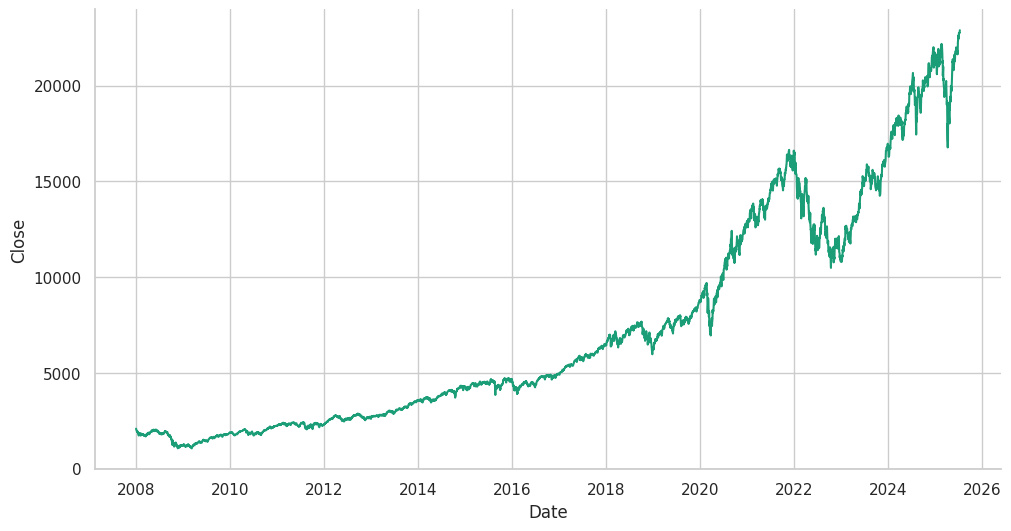

In [29]:
# @title Date vs Close

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Close']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Close')

In [20]:
for n in [1, 5, 10, 15, 20]:
    df[f'Return_Lag_{n}'] = df['Close'].pct_change(n)
df['Volatility_10'] = df['Return'].rolling(10).std()
df['Volatility_20'] = df['Return'].rolling(20).std()
range_pct = (df['High'] - df['Low']) / df['Close']
df['Range_Z'] = (range_pct - range_pct.rolling(20).mean()) / range_pct.rolling(20).std()
df['Volume_Z'] = (df['Volume'] - df['Volume'].rolling(20).mean()) / df['Volume'].rolling(20).std()
df['MA50_Diff'] = df['Close'] / df['Close'].rolling(50).mean() - 1
df['MA200_Diff'] = df['Close'] / df['Close'].rolling(200).mean() - 1
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0).rolling(14).mean()
loss = -delta.where(delta < 0, 0).rolling(14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))
df['Close_Position'] = (df['Close'] - df['Low']) / (df['High'] - df['Low'])
df['Weekday'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month
df = pd.get_dummies(df, columns=['Weekday', 'Month'], drop_first=True)
df.dropna(inplace=True)

In [21]:
features = [col for col in df.columns if col.startswith(('Return_Lag_', 'Volatility_', 'Range_Z',
           'Volume_Z', 'MA50_Diff', 'MA200_Diff', 'RSI', 'Close_Position', 'Weekday_', 'Month_'))]
X = df[features]
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [22]:
baseline_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
baseline_model.fit(X_train, y_train)
train_preds = baseline_model.predict(X_train)
test_preds = baseline_model.predict(X_test)
train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Training Accuracy: 1.0000
Test Accuracy: 0.7494


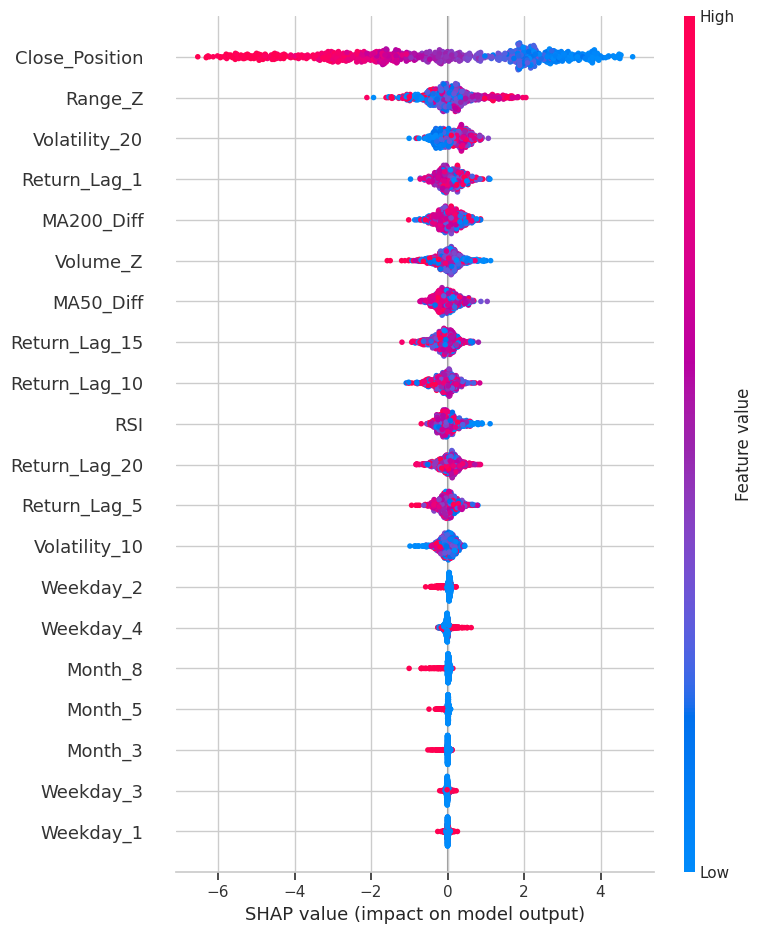

In [23]:
explainer = shap.TreeExplainer(baseline_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)